**Idea inicial, arquitectura inicial de la CNN y usa carry-forward imputation, mas cantidad de mediciones en cada intervalo**

Necesary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os, time, random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import metrics
import itertools
from sklearn import preprocessing

Loading the data:

**Just run the next box to download the data**

In [6]:
# Run this just the first time
#!pip install -U wget
#!rm -rf data.zip data lib
#!rm -rf preprocessed
!mkdir -p preprocessed
!mkdir -p lib

import wget
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/config.yaml', 'lib/config.yaml')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/helper.py', 'lib/helper.py')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/data.zip', 'data.zip')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/preprocessed/data_seq.npz', 'preprocessed/data_seq.npz')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/prepare_data.py', 'lib/prepare_data.py')

import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [2]:
#Run this to load the data if you have downloaded the data before
from lib.helper import load_data
raw_data, df_labels = load_data(120000)

Loading files from disk: 100%|██████████| 12000/12000 [01:41<00:00, 118.50it/s]


In [3]:
# GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cpu


Preparing data:

In [20]:
%run lib/prepare_data_CF_dist-time_backw.py

/home/damorgal/Documents/BDSI_project/lib/prepare_data_CF_dist-time_backw.py:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open('lib/config.yaml'))
Generating feature vectors: 100%|██████████| 10000/10000 [3:04:49<00:00,  1.11s/it] 


(10000, 48, 70) (10000,)


In [4]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()
    def __len__(self):
        return len(self.X)

def get_train_val_test(batch_size=64):
    #f = np.load('preprocessed/data_seq.npz')
    f = np.load('data/data_nmiss_CF.npz')
    f2 = np.load('data/data_miss_CF.npz')
    f3 = np.load('data/data_dist_backw.npz')
    f4 = np.load('data/data_times_backw_neg.npz')
    X, y = f['X'], f['y']
    X = np.concatenate((X,f2['X'],f3['X'],f4['X']), axis=2)
    X = X.transpose((0,2,1))
    print(X.shape, y.shape)
    
    print('Creating splits')
    Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=0)
    Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=0)
    
    tr = SimpleDataset(Xtr, ytr)
    va = SimpleDataset(Xva, yva)
    te = SimpleDataset(Xte, yte)
    
    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(va, batch_size=batch_size)
    te_loader = DataLoader(te, batch_size=batch_size)
    
    print('Feature shape, Label shape, Class balance:')
    print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
    print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
    print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
    return tr_loader, va_loader, te_loader

In [5]:
tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

(10000, 140, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Feature shape, Label shape, Class balance:
	 (8000, 140, 48) (8000,) 0.142875
	 (1000, 140, 48) (1000,) 0.143
	 (1000, 140, 48) (1000,) 0.143


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels, n_filters, output_size, sequence_len):
        super().__init__()
        self.n_filters = n_filters
        self.conv1 = nn.Conv1d(in_channels, n_filters, 3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_filters, n_filters, 3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.fc = nn.Linear(int(sequence_len/2/2)*n_filters+1*1680, output_size)

    def forward(self, x):
        xm = 1 - x[:,35:70,:]
        xd = x[:,70:105,:]
        xt = x[:,105:,:]
        x = x[:,:35,:]
        N, d, L = x.shape
        #x = torch.Tensor(np.concatenate((x,xd,xt), axis=1))
        #ones = np.array([np.array([np.ones(L) for i in range(d)]) for j in range(N)])
        #xm = torch.Tensor(np.concatenate((xm,ones,ones), axis=1))
        
        # Getting the weights for the trained model
        z = self.conv1(x)
        w = self.conv1.weight
        wm = torch.abs(w) / torch.sum(torch.abs(w), dim=(1,2), keepdim=True)
        
        # Apply the weights to the mask xm
        zm = F.conv1d(xm, wm, padding=1)
        
        # Apply the first set of conv-elu-pool
        z = self.pool1(zm*F.elu(z))
        
        # Apply the second set of conv-elu-pool
        z = self.pool2(F.elu(self.conv2(z)))
        
        # Flatten the output from the convolutional/pooling layers
        z = z.view(N, -1)
        # Flatten tensors
        xd = xd.view(N,-1)
        xt = xt.view(N,-1)
        
        # Add the distance and times of measurements
        z = torch.cat((z,xd,xt),1)
        #z = torch.cat((z,xt),1)
        z = self.fc(z)
        
        # Pass through the output layer and apply sigmoid activation
        z = torch.sigmoid(z)

        return z

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = CNN(35, 64, 1, 48)
print('Number of float-valued parameters:', count_parameters(model))

Number of float-valued parameters: 21585


In [8]:
x = torch.zeros((1, 35*4, 48))
model(x)

tensor([[0.5035]], grad_fn=<SigmoidBackward>)

Train the LSTM:

In [9]:
def _train_epoch(data_loader, model, criterion, optimizer):
    """
    Train the `model` for one epoch of data from `data_loader`
    Use `optimizer` to optimize the specified `criterion`
    """
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

def _evaluate_epoch(tr_loader, va_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        # Evaluate on train
        y_true, y_score = [], []
        running_loss = []
        for X, y in tr_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            y_true.append(y.cpu().numpy())
            y_score.append(output.cpu().numpy())
            running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        train_loss = np.mean(running_loss)
        train_score = metrics.roc_auc_score(y_true, y_score)
        print('tr loss', train_loss, 'tr AUROC', train_score)

        # Evaluate on validation
        y_true, y_score = [], []
        running_loss = []
        for X, y in va_loader:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                output = model(X)
                y_true.append(y.cpu().numpy())
                y_score.append(output.cpu().numpy())
                running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        val_loss = np.mean(running_loss)
        val_score = metrics.roc_auc_score(y_true, y_score)
        print('va loss', val_loss, 'va AUROC', val_score)
    return train_loss, val_loss, train_score, val_score

def save_checkpoint(model, epoch, checkpoint_dir):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
    }

    filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(epoch))
    torch.save(state, filename)

(10000, 140, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Feature shape, Label shape, Class balance:
	 (8000, 140, 48) (8000,) 0.142875
	 (1000, 140, 48) (1000,) 0.143
	 (1000, 140, 48) (1000,) 0.143
Number of float-valued parameters: 21585
Epoch 0
tr loss 0.6938018698692322 tr AUROC 0.48760008068847016
va loss 0.6948166824877262 va AUROC 0.4988045793179982
Epoch 1
tr loss 0.30677544498443604 tr AUROC 0.8429378641363865
va loss 0.3295658193528652 va AUROC 0.8219027180520764
Epoch 2
tr loss 0.29100729036331174 tr AUROC 0.8609288794420604
va loss 0.32010232750326395 va AUROC 0.8325513459702492
Epoch 3
tr loss 0.2810714260935783 tr AUROC 0.8705058506158365
va loss 0.31991249043494463 va AUROC 0.8336529281686809
Epoch 4
tr loss 0.2781189783811569 tr AUROC 0.8825656126511967
va loss 0.33137581404298544 va AUROC 0.8230940588000097
Epoch 5
tr loss 0.2642206914424896 tr AUROC 0.892138118144303
va loss 0.33454680629074574 va AUROC 0.8201320266664491
Epoch 6
tr loss 0.25409805369377136 tr AUROC 0.9036477721165704
va loss 0.33284664526581764 va AUROC 0.

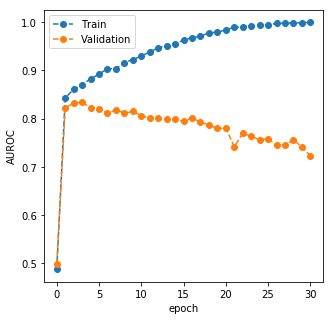

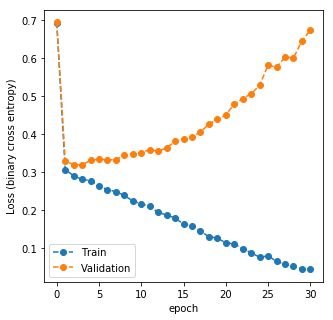

In [10]:
#!mkdir -p checkpoint

tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)
    
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

n_epochs = 30
learning_rate = 1e-3

model = CNN(35*1, 64, 1, 48)
print('Number of float-valued parameters:', count_parameters(model))

model = model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

outputs = []

print('Epoch', 0)
out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
outputs.append(out)

for epoch in range(0, n_epochs):
    print('Epoch', epoch+1)
    # Train model
    _train_epoch(tr_loader, model, criterion, optimizer)

    # Evaluate model
    out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
    outputs.append(out)

    # Save model parameters
    save_checkpoint(model, epoch+1, 'checkpoint/')

train_losses, val_losses, train_scores, val_scores = zip(*outputs)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_scores, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_scores, '--o', label='Validation')
plt.xlabel('epoch')
plt.ylabel('AUROC')
plt.legend()
plt.savefig('auroc_dist_times_backw.png', dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_losses, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_losses, '--o', label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss (binary cross entropy)')
plt.legend()
plt.savefig('loss_dist_times_backw.png', dpi=300)


Evaluation on test set

In [14]:
def restore_checkpoint(model, checkpoint_dir, cuda=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model and the current epoch.
    """
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
        if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception("Checkpoint not found")
        else:
            return model, 0, []
    
    # Find latest epoch
    for i in itertools.count(1):
        if 'epoch={}.checkpoint.pth.tar'.format(i) in cp_files:
            epoch = i
        else:
            break

    print("Which epoch to load from? Choose in range [1, {}].".format(epoch))
    inp_epoch = int(input())
    if inp_epoch not in range(1, epoch+1):
        raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    print("Loading from checkpoint {}".format(filename))
    
    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename,
            map_location=lambda storage, loc: storage)

    try:
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Successfully restored checkpoint (trained for {} epochs)"
            .format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch

def _evaluate_epoch(data_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        y_true, y_score = [], []
        running_loss = []
        for X, y in data_loader:
            output = model(X)
            y_true.append(y.numpy())
            y_score.append(output)
            running_loss.append(criterion(output, y).item())
        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
    
    loss = np.mean(running_loss)
    score = metrics.roc_auc_score(y_true, y_score)
    return loss, score

_, _, te_loader = get_train_val_test(batch_size=64)
model = CNN(35*1, 64, 1, 48)
model, _ = restore_checkpoint(model, 'checkpoint/')
criterion = torch.nn.BCELoss()
loss, score = _evaluate_epoch(te_loader, model, criterion)
print('Test loss :', loss)
print('Test AUROC:', score)

(10000, 140, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Feature shape, Label shape, Class balance:
	 (8000, 140, 48) (8000,) 0.142875
	 (1000, 140, 48) (1000,) 0.143
	 (1000, 140, 48) (1000,) 0.143
Which epoch to load from? Choose in range [1, 30].
3
Loading from checkpoint checkpoint/epoch=3.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 3 epochs)
Test loss : 0.3602591771632433
Test AUROC: 0.7843918042284437
